In [1]:
import os
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
from tensorflow.python.client import timeline
import CapsNet

In [2]:
tf.reset_default_graph()
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
from tensorflow.keras.datasets.mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()

In [4]:
X_test = X_test / 255
X_train = X_train / 255

train_split = 0.8

samples = len(X_train)
split = int(samples * train_split)
X_valid = X_train[split:]
X_train = X_train[:split]
y_valid = y_train[split:]
y_train = y_train[:split]

print('No. training examples: %d, No. training labels:%d' % (len(X_train),
                                                             len(y_train)))
print('No. Valid examples: %d, No. Valid labels: %d' % (len(X_valid),
                                                        len(y_valid)))

No. training examples: 48000, No. training labels:48000
No. Valid examples: 12000, No. Valid labels: 12000


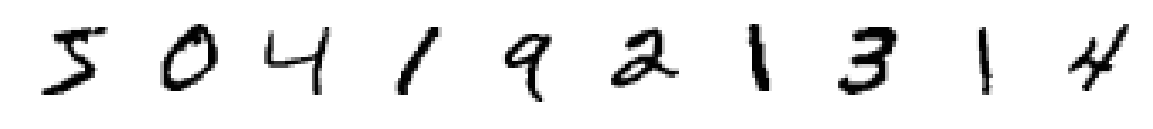

In [5]:
n_samples = 10
plt.figure(figsize=(n_samples * 2, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    sample_image = X_train[i].reshape(28,28)
    plt.imshow(sample_image, cmap='binary')
    plt.axis('off')
    
plt.show()

In [6]:
y_train[:n_samples]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [7]:
def get_next_batch(batch_size, X, y):
    for start in range(0, len(X), batch_size):
        end = min(start + batch_size, len(X))
        yield X[start:end], y[start:end]

In [8]:
#training
num_epochs = 10
batch_size = 32
restore_checkpoint = True

n_iter_per_epoch = len(X_train) // batch_size
n_iter_per_val = len(X_valid) // batch_size
best_loss_val = np.infty
checkpoint_path = './capsnetv2'

height = 28
width = 28
channels = 1
num_labels = 10

X = tf.placeholder(shape=[None, height, width, channels], dtype=tf.float32, name='X')
y = tf.placeholder(shape=[None], dtype=tf.int64, name='y')
net = CapsNet.CapsNet(height=height, width=width, channels=channels, num_labels=num_labels)
net.make_network(X, y)
loss, train_ops, summary_ops = net.train()

init = tf.global_variables_initializer()
saver = tf.train.Saver()
write_every = 50
summary_writer = tf.summary.FileWriter('./capsnetv2Logs')
summary_writer.add_graph(tf.get_default_graph())

run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.Session(config=config) as sess:
    if restore_checkpoint and tf.train.checkpoint_exists(checkpoint_path):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        
        for e in range(num_epochs):
            for i, (X_batch, y_batch) in enumerate(get_next_batch(batch_size, X_train, y_train)):
                step = (e + 1) * (i + 1)
                if step % write_every == 0:
                    _, loss_train, summary = sess.run(
                         [train_ops, loss, summary_ops],
                         feed_dict = {X : X_batch.reshape([-1, 28, 28, 1]),
                                      y : y_batch})
                
                    summary_writer.add_summary(summary, step)
                
                else:
                    _, loss_train = sess.run(
                        [train_ops, loss],
                        feed_dict = {X : X_batch.reshape([-1, 28, 28, 1]),
                                     y : y_batch})
                    
                print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                      i, n_iter_per_epoch,
                      i * 100 / n_iter_per_epoch,
                      loss_train),
                      end="")
            
            loss_vals = []
            acc_vals = []
            for i, (X_batch, y_batch) in enumerate(get_next_batch(batch_size, X_valid, y_valid)):
                loss_val, acc_val = sess.run(
                    [loss, net.accuracy],
                    feed_dict = {X : X_batch.reshape([-1, 28, 28, 1]),
                                 y : y_batch})
                
                loss_vals.append(loss_val)
                acc_vals.append(acc_val)
                loss_val = np.mean(loss_vals)
                acc_val = np.mean(acc_vals)
                print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
                    e + 1, acc_val * 100, loss_val,
                    " (improved)" if loss_val < best_loss_val else ""))
            
                if loss_val < best_loss_val:
                    save_path = saver.save(sess, checkpoint_path)
                    best_loss_val = loss_val

Epoch: 1  Val accuracy: 81.2500%  Loss: 0.106047 (improved)
Epoch: 1  Val accuracy: 82.8125%  Loss: 0.094110 (improved)
Epoch: 1  Val accuracy: 79.1667%  Loss: 0.089344 (improved)
Epoch: 1  Val accuracy: 80.4688%  Loss: 0.081246 (improved)
Epoch: 1  Val accuracy: 80.6250%  Loss: 0.084594
Epoch: 1  Val accuracy: 80.7292%  Loss: 0.078620 (improved)
Epoch: 1  Val accuracy: 81.6964%  Loss: 0.077271 (improved)
Epoch: 1  Val accuracy: 80.4688%  Loss: 0.076211 (improved)
Epoch: 1  Val accuracy: 79.8611%  Loss: 0.077203
Epoch: 1  Val accuracy: 79.6875%  Loss: 0.078086
Epoch: 1  Val accuracy: 79.2614%  Loss: 0.083360
Epoch: 1  Val accuracy: 77.6042%  Loss: 0.084722
Epoch: 1  Val accuracy: 77.6442%  Loss: 0.085996
Epoch: 1  Val accuracy: 77.9018%  Loss: 0.084590
Epoch: 1  Val accuracy: 78.3333%  Loss: 0.083475
Epoch: 1  Val accuracy: 78.1250%  Loss: 0.083110
Epoch: 1  Val accuracy: 77.5735%  Loss: 0.084323
Epoch: 1  Val accuracy: 77.6042%  Loss: 0.085003
Epoch: 1  Val accuracy: 77.1382%  Loss: 0

Epoch: 1  Val accuracy: 78.3121%  Loss: 0.087166
Epoch: 1  Val accuracy: 78.3482%  Loss: 0.087005
Epoch: 1  Val accuracy: 78.3284%  Loss: 0.087027
Epoch: 1  Val accuracy: 78.3456%  Loss: 0.087068
Epoch: 1  Val accuracy: 78.3260%  Loss: 0.086963
Epoch: 1  Val accuracy: 78.3249%  Loss: 0.087005
Epoch: 1  Val accuracy: 78.3598%  Loss: 0.086837
Epoch: 1  Val accuracy: 78.3046%  Loss: 0.086901
Epoch: 1  Val accuracy: 78.2857%  Loss: 0.086976
Epoch: 1  Val accuracy: 78.3203%  Loss: 0.086789
Epoch: 1  Val accuracy: 78.3545%  Loss: 0.086771
Epoch: 1  Val accuracy: 78.3181%  Loss: 0.086793
Epoch: 1  Val accuracy: 78.3170%  Loss: 0.086677
Epoch: 1  Val accuracy: 78.2292%  Loss: 0.086899
Epoch: 1  Val accuracy: 78.2804%  Loss: 0.086698
Epoch: 1  Val accuracy: 78.2624%  Loss: 0.086627
Epoch: 1  Val accuracy: 78.3128%  Loss: 0.086494
Epoch: 1  Val accuracy: 78.3288%  Loss: 0.086569
Epoch: 1  Val accuracy: 78.2601%  Loss: 0.086587
Epoch: 1  Val accuracy: 78.2930%  Loss: 0.086452
Epoch: 1  Val accura

Epoch: 1  Val accuracy: 79.3563%  Loss: 0.084057
Epoch: 1  Val accuracy: 79.3899%  Loss: 0.083985
Epoch: 1  Val accuracy: 79.3954%  Loss: 0.083912
Epoch: 1  Val accuracy: 79.3362%  Loss: 0.084005
Epoch: 1  Val accuracy: 79.3142%  Loss: 0.083992
Epoch: 1  Val accuracy: 79.3199%  Loss: 0.083967
Epoch: 1  Val accuracy: 79.3713%  Loss: 0.083829
Epoch: 1  Val accuracy: 79.4134%  Loss: 0.083709
Epoch: 1  Val accuracy: 79.4552%  Loss: 0.083551
Epoch: 1  Val accuracy: 79.4967%  Loss: 0.083414
Epoch: 1  Val accuracy: 79.5199%  Loss: 0.083300
Epoch: 1  Val accuracy: 79.5520%  Loss: 0.083169
Epoch: 1  Val accuracy: 79.5659%  Loss: 0.083099
Epoch: 1  Val accuracy: 79.5977%  Loss: 0.083009
Epoch: 1  Val accuracy: 79.6114%  Loss: 0.082930
Epoch: 1  Val accuracy: 79.6339%  Loss: 0.082847
Epoch: 1  Val accuracy: 79.6385%  Loss: 0.082776
Epoch: 1  Val accuracy: 79.6431%  Loss: 0.082698
Epoch: 1  Val accuracy: 79.6034%  Loss: 0.082909
Epoch: 1  Val accuracy: 79.5816%  Loss: 0.083320
Epoch: 1  Val accura

Epoch: 2  Val accuracy: 83.4573%  Loss: 0.076923
Epoch: 2  Val accuracy: 83.4646%  Loss: 0.077003
Epoch: 2  Val accuracy: 83.3984%  Loss: 0.077189
Epoch: 2  Val accuracy: 83.2607%  Loss: 0.077452
Epoch: 2  Val accuracy: 83.2933%  Loss: 0.077584
Epoch: 2  Val accuracy: 83.2300%  Loss: 0.077657
Epoch: 2  Val accuracy: 83.2150%  Loss: 0.077573
Epoch: 2  Val accuracy: 83.1532%  Loss: 0.077945
Epoch: 2  Val accuracy: 83.1390%  Loss: 0.078299
Epoch: 2  Val accuracy: 83.1713%  Loss: 0.078200
Epoch: 2  Val accuracy: 83.2491%  Loss: 0.077840
Epoch: 2  Val accuracy: 83.2345%  Loss: 0.077793
Epoch: 2  Val accuracy: 83.3333%  Loss: 0.077498
Epoch: 2  Val accuracy: 83.4308%  Loss: 0.077218
Epoch: 2  Val accuracy: 83.5045%  Loss: 0.076957
Epoch: 2  Val accuracy: 83.5993%  Loss: 0.076650
Epoch: 2  Val accuracy: 83.6268%  Loss: 0.076594
Epoch: 2  Val accuracy: 83.6757%  Loss: 0.076414
Epoch: 2  Val accuracy: 83.7674%  Loss: 0.076198
Epoch: 2  Val accuracy: 83.8147%  Loss: 0.075999
Epoch: 2  Val accura

Epoch: 2  Val accuracy: 84.8214%  Loss: 0.071750
Epoch: 2  Val accuracy: 84.8623%  Loss: 0.071699
Epoch: 2  Val accuracy: 84.8818%  Loss: 0.071607
Epoch: 2  Val accuracy: 84.8695%  Loss: 0.071628
Epoch: 2  Val accuracy: 84.8993%  Loss: 0.071546
Epoch: 2  Val accuracy: 84.9080%  Loss: 0.071464
Epoch: 2  Val accuracy: 84.8854%  Loss: 0.071492
Epoch: 2  Val accuracy: 84.8526%  Loss: 0.071552
Epoch: 2  Val accuracy: 84.8406%  Loss: 0.071513
Epoch: 2  Val accuracy: 84.8391%  Loss: 0.071550
Epoch: 2  Val accuracy: 84.8581%  Loss: 0.071568
Epoch: 2  Val accuracy: 84.8566%  Loss: 0.071624
Epoch: 2  Val accuracy: 84.8550%  Loss: 0.071667
Epoch: 2  Val accuracy: 84.8636%  Loss: 0.071609
Epoch: 2  Val accuracy: 84.8925%  Loss: 0.071549
Epoch: 2  Val accuracy: 84.9110%  Loss: 0.071468
Epoch: 2  Val accuracy: 84.9194%  Loss: 0.071466
Epoch: 2  Val accuracy: 84.9176%  Loss: 0.071458
Epoch: 2  Val accuracy: 84.9159%  Loss: 0.071414
Epoch: 2  Val accuracy: 84.9042%  Loss: 0.071431
Epoch: 2  Val accura

Epoch: 3  Val accuracy: 91.0662%  Loss: 0.055420
Epoch: 3  Val accuracy: 91.0610%  Loss: 0.055345
Epoch: 3  Val accuracy: 91.0560%  Loss: 0.055283
Epoch: 3  Val accuracy: 91.0511%  Loss: 0.055328
Epoch: 3  Val accuracy: 90.9059%  Loss: 0.055527
Epoch: 3  Val accuracy: 91.0069%  Loss: 0.055144
Epoch: 3  Val accuracy: 90.7624%  Loss: 0.055564
Epoch: 3  Val accuracy: 90.8288%  Loss: 0.055500
Epoch: 3  Val accuracy: 90.8938%  Loss: 0.055325
Epoch: 3  Val accuracy: 90.8577%  Loss: 0.055276
Epoch: 3  Val accuracy: 90.8882%  Loss: 0.055012
Epoch: 3  Val accuracy: 90.9831%  Loss: 0.054676
Epoch: 3  Val accuracy: 90.9149%  Loss: 0.054788
Epoch: 3  Val accuracy: 90.9120%  Loss: 0.054680
Epoch: 3  Val accuracy: 90.9091%  Loss: 0.054702
Epoch: 3  Val accuracy: 90.9375%  Loss: 0.054556
Epoch: 3  Val accuracy: 90.9344%  Loss: 0.054549
Epoch: 3  Val accuracy: 90.8088%  Loss: 0.054587
Epoch: 3  Val accuracy: 90.8070%  Loss: 0.054448
Epoch: 3  Val accuracy: 90.8654%  Loss: 0.054280
Epoch: 3  Val accura

Epoch: 3  Val accuracy: 92.0455%  Loss: 0.050741
Epoch: 3  Val accuracy: 92.0522%  Loss: 0.050699
Epoch: 3  Val accuracy: 92.0711%  Loss: 0.050630
Epoch: 3  Val accuracy: 92.0288%  Loss: 0.050720
Epoch: 3  Val accuracy: 92.0233%  Loss: 0.050791
Epoch: 3  Val accuracy: 92.0179%  Loss: 0.050827
Epoch: 3  Val accuracy: 92.0125%  Loss: 0.050789
Epoch: 3  Val accuracy: 92.0192%  Loss: 0.050800
Epoch: 3  Val accuracy: 92.0259%  Loss: 0.050802
Epoch: 3  Val accuracy: 92.0205%  Loss: 0.050830
Epoch: 3  Val accuracy: 92.0390%  Loss: 0.050863
Epoch: 3  Val accuracy: 92.0455%  Loss: 0.050903
Epoch: 3  Val accuracy: 92.0283%  Loss: 0.051039
Epoch: 3  Val accuracy: 92.0583%  Loss: 0.051001
Epoch: 3  Val accuracy: 92.0412%  Loss: 0.051050
Epoch: 3  Val accuracy: 92.0359%  Loss: 0.051011
Epoch: 3  Val accuracy: 92.0423%  Loss: 0.051026
Epoch: 3  Val accuracy: 92.0602%  Loss: 0.050957
Epoch: 3  Val accuracy: 92.0664%  Loss: 0.050963
Epoch: 3  Val accuracy: 92.0841%  Loss: 0.050898
Epoch: 3  Val accura

Epoch: 4  Val accuracy: 92.3913%  Loss: 0.056181
Epoch: 4  Val accuracy: 92.1543%  Loss: 0.057121
Epoch: 4  Val accuracy: 91.9922%  Loss: 0.057722
Epoch: 4  Val accuracy: 91.7730%  Loss: 0.058929
Epoch: 4  Val accuracy: 91.5000%  Loss: 0.059628
Epoch: 4  Val accuracy: 91.4828%  Loss: 0.059221
Epoch: 4  Val accuracy: 91.4663%  Loss: 0.059125
Epoch: 4  Val accuracy: 91.6274%  Loss: 0.058622
Epoch: 4  Val accuracy: 91.7245%  Loss: 0.058080
Epoch: 4  Val accuracy: 91.7045%  Loss: 0.057815
Epoch: 4  Val accuracy: 91.7411%  Loss: 0.057649
Epoch: 4  Val accuracy: 91.7215%  Loss: 0.057556
Epoch: 4  Val accuracy: 91.8642%  Loss: 0.057184
Epoch: 4  Val accuracy: 91.8962%  Loss: 0.056849
Epoch: 4  Val accuracy: 91.6667%  Loss: 0.057447
Epoch: 4  Val accuracy: 91.7520%  Loss: 0.057072
Epoch: 4  Val accuracy: 91.7843%  Loss: 0.057379
Epoch: 4  Val accuracy: 91.7659%  Loss: 0.057696
Epoch: 4  Val accuracy: 91.8945%  Loss: 0.057292
Epoch: 4  Val accuracy: 91.8750%  Loss: 0.057258
Epoch: 4  Val accura

Epoch: 4  Val accuracy: 92.6402%  Loss: 0.054235
Epoch: 4  Val accuracy: 92.6308%  Loss: 0.054366
Epoch: 4  Val accuracy: 92.6505%  Loss: 0.054358
Epoch: 4  Val accuracy: 92.5691%  Loss: 0.054425
Epoch: 4  Val accuracy: 92.5459%  Loss: 0.054406
Epoch: 4  Val accuracy: 92.5656%  Loss: 0.054336
Epoch: 4  Val accuracy: 92.5710%  Loss: 0.054302
Epoch: 4  Val accuracy: 92.6046%  Loss: 0.054201
Epoch: 4  Val accuracy: 92.6239%  Loss: 0.054106
Epoch: 4  Val accuracy: 92.6429%  Loss: 0.054011
Epoch: 4  Val accuracy: 92.6618%  Loss: 0.053917
Epoch: 4  Val accuracy: 92.6389%  Loss: 0.053958
Epoch: 4  Val accuracy: 92.6715%  Loss: 0.053830
Epoch: 4  Val accuracy: 92.7037%  Loss: 0.053741
Epoch: 4  Val accuracy: 92.7083%  Loss: 0.053919
Epoch: 4  Val accuracy: 92.7265%  Loss: 0.053874
Epoch: 4  Val accuracy: 92.7310%  Loss: 0.054004
Epoch: 4  Val accuracy: 92.7489%  Loss: 0.053923
Epoch: 4  Val accuracy: 92.7398%  Loss: 0.053873
Epoch: 4  Val accuracy: 92.7575%  Loss: 0.053828
Epoch: 4  Val accura

Epoch: 5  Val accuracy: 96.4844%  Loss: 0.042693
Epoch: 5  Val accuracy: 96.1806%  Loss: 0.045374
Epoch: 5  Val accuracy: 95.9375%  Loss: 0.047029
Epoch: 5  Val accuracy: 95.1705%  Loss: 0.047986
Epoch: 5  Val accuracy: 94.5312%  Loss: 0.051127
Epoch: 5  Val accuracy: 94.7115%  Loss: 0.050542
Epoch: 5  Val accuracy: 95.0893%  Loss: 0.049089
Epoch: 5  Val accuracy: 95.2083%  Loss: 0.048357
Epoch: 5  Val accuracy: 95.3125%  Loss: 0.047656
Epoch: 5  Val accuracy: 95.2206%  Loss: 0.048014
Epoch: 5  Val accuracy: 95.3125%  Loss: 0.047982
Epoch: 5  Val accuracy: 95.3947%  Loss: 0.047355
Epoch: 5  Val accuracy: 95.6250%  Loss: 0.046425
Epoch: 5  Val accuracy: 95.3869%  Loss: 0.046310
Epoch: 5  Val accuracy: 95.4545%  Loss: 0.045970
Epoch: 5  Val accuracy: 95.5163%  Loss: 0.046416
Epoch: 5  Val accuracy: 95.4427%  Loss: 0.046116
Epoch: 5  Val accuracy: 95.3750%  Loss: 0.045866
Epoch: 5  Val accuracy: 95.3125%  Loss: 0.047097
Epoch: 5  Val accuracy: 95.1389%  Loss: 0.047307
Epoch: 5  Val accura

Epoch: 5  Val accuracy: 94.0696%  Loss: 0.050791
Epoch: 5  Val accuracy: 94.0678%  Loss: 0.050945
Epoch: 5  Val accuracy: 94.0485%  Loss: 0.050944
Epoch: 5  Val accuracy: 94.0642%  Loss: 0.051017
Epoch: 5  Val accuracy: 94.0451%  Loss: 0.051061
Epoch: 5  Val accuracy: 94.0608%  Loss: 0.050915
Epoch: 5  Val accuracy: 94.0591%  Loss: 0.050823
Epoch: 5  Val accuracy: 94.0574%  Loss: 0.050734
Epoch: 5  Val accuracy: 94.0387%  Loss: 0.050870
Epoch: 5  Val accuracy: 94.0541%  Loss: 0.050864
Epoch: 5  Val accuracy: 94.0188%  Loss: 0.051051
Epoch: 5  Val accuracy: 94.0341%  Loss: 0.051124
Epoch: 5  Val accuracy: 94.0492%  Loss: 0.051055
Epoch: 5  Val accuracy: 94.0642%  Loss: 0.051033
Epoch: 5  Val accuracy: 94.0461%  Loss: 0.051091
Epoch: 5  Val accuracy: 94.0281%  Loss: 0.051057
Epoch: 5  Val accuracy: 94.0592%  Loss: 0.050927
Epoch: 5  Val accuracy: 94.0738%  Loss: 0.050836
Epoch: 5  Val accuracy: 94.0883%  Loss: 0.050778
Epoch: 5  Val accuracy: 94.1186%  Loss: 0.050637
Epoch: 5  Val accura

Epoch: 5  Val accuracy: 94.4858%  Loss: 0.048637
Epoch: 5  Val accuracy: 94.5018%  Loss: 0.048556
Epoch: 5  Val accuracy: 94.5177%  Loss: 0.048477
Epoch: 5  Val accuracy: 94.5335%  Loss: 0.048396
Epoch: 5  Val accuracy: 94.5492%  Loss: 0.048313
Epoch: 5  Val accuracy: 94.5559%  Loss: 0.048249
Epoch: 5  Val accuracy: 94.5714%  Loss: 0.048177
Epoch: 5  Val accuracy: 94.5780%  Loss: 0.048128
Epoch: 5  Val accuracy: 94.5845%  Loss: 0.048059
Epoch: 5  Val accuracy: 94.5910%  Loss: 0.048096
Epoch: 5  Val accuracy: 94.5621%  Loss: 0.048307
Epoch: 5  Val accuracy: 94.5158%  Loss: 0.048628
Epoch: 5  Val accuracy: 94.4786%  Loss: 0.048789
Epoch: 5  Val accuracy: 94.4678%  Loss: 0.048836
Epoch: 5  Val accuracy: 94.4396%  Loss: 0.048920
Epoch: 5  Val accuracy: 94.4203%  Loss: 0.048945
Epoch: 5  Val accuracy: 94.4184%  Loss: 0.048881
Epoch: 5  Val accuracy: 94.4339%  Loss: 0.048807
Epoch: 5  Val accuracy: 94.4492%  Loss: 0.048745
Epoch: 5  Val accuracy: 94.4559%  Loss: 0.048705
Epoch: 5  Val accura

Epoch: 6  Val accuracy: 92.8895%  Loss: 0.062139
Epoch: 6  Val accuracy: 92.9182%  Loss: 0.061985
Epoch: 6  Val accuracy: 92.9464%  Loss: 0.061771
Epoch: 6  Val accuracy: 92.9743%  Loss: 0.061539
Epoch: 6  Val accuracy: 92.9798%  Loss: 0.061367
Epoch: 6  Val accuracy: 92.9851%  Loss: 0.061223
Epoch: 6  Val accuracy: 93.0122%  Loss: 0.061040
Epoch: 6  Val accuracy: 93.0388%  Loss: 0.060976
Epoch: 6  Val accuracy: 93.0223%  Loss: 0.061131
Epoch: 6  Val accuracy: 92.9847%  Loss: 0.061187
Epoch: 6  Val accuracy: 92.9688%  Loss: 0.061358
Epoch: 6  Val accuracy: 92.9530%  Loss: 0.061263
Epoch: 6  Val accuracy: 92.9583%  Loss: 0.061234
Epoch: 6  Val accuracy: 92.8394%  Loss: 0.061458
Epoch: 6  Val accuracy: 92.8454%  Loss: 0.061374
Epoch: 6  Val accuracy: 92.8309%  Loss: 0.061327
Epoch: 6  Val accuracy: 92.7963%  Loss: 0.061462
Epoch: 6  Val accuracy: 92.7419%  Loss: 0.061782
Epoch: 6  Val accuracy: 92.7284%  Loss: 0.062017
Epoch: 6  Val accuracy: 92.7548%  Loss: 0.062101
Epoch: 6  Val accura

Epoch: 6  Val accuracy: 93.3926%  Loss: 0.060059
Epoch: 6  Val accuracy: 93.3836%  Loss: 0.060070
Epoch: 6  Val accuracy: 93.4050%  Loss: 0.059973
Epoch: 6  Val accuracy: 93.4061%  Loss: 0.059887
Epoch: 6  Val accuracy: 93.3871%  Loss: 0.059860
Epoch: 6  Val accuracy: 93.3983%  Loss: 0.059805
Epoch: 6  Val accuracy: 93.3594%  Loss: 0.059852
Epoch: 6  Val accuracy: 93.3407%  Loss: 0.059838
Epoch: 6  Val accuracy: 93.3420%  Loss: 0.059805
Epoch: 6  Val accuracy: 93.3333%  Loss: 0.059882
Epoch: 6  Val accuracy: 93.3347%  Loss: 0.060055
Epoch: 6  Val accuracy: 93.3261%  Loss: 0.059996
Epoch: 6  Val accuracy: 93.3373%  Loss: 0.059925
Epoch: 6  Val accuracy: 93.3484%  Loss: 0.059843
Epoch: 6  Val accuracy: 93.3691%  Loss: 0.059740
Epoch: 6  Val accuracy: 93.3801%  Loss: 0.059683
Epoch: 6  Val accuracy: 93.4006%  Loss: 0.059582
Epoch: 6  Val accuracy: 93.3727%  Loss: 0.059661
Epoch: 6  Val accuracy: 93.3738%  Loss: 0.059614
Epoch: 6  Val accuracy: 93.3750%  Loss: 0.059627
Epoch: 6  Val accura

Epoch: 7  Val accuracy: 94.2187%  Loss: 0.062127
Epoch: 7  Val accuracy: 94.2141%  Loss: 0.061959
Epoch: 7  Val accuracy: 94.1789%  Loss: 0.062404
Epoch: 7  Val accuracy: 94.2051%  Loss: 0.062116
Epoch: 7  Val accuracy: 94.2308%  Loss: 0.061995
Epoch: 7  Val accuracy: 94.2560%  Loss: 0.061781
Epoch: 7  Val accuracy: 94.2807%  Loss: 0.061772
Epoch: 7  Val accuracy: 94.3049%  Loss: 0.061538
Epoch: 7  Val accuracy: 94.2998%  Loss: 0.061588
Epoch: 7  Val accuracy: 94.2661%  Loss: 0.061888
Epoch: 7  Val accuracy: 94.2898%  Loss: 0.061651
Epoch: 7  Val accuracy: 94.3131%  Loss: 0.062064
Epoch: 7  Val accuracy: 94.3359%  Loss: 0.061873
Epoch: 7  Val accuracy: 94.3584%  Loss: 0.061753
Epoch: 7  Val accuracy: 94.4079%  Loss: 0.061508
Epoch: 7  Val accuracy: 94.4022%  Loss: 0.061299
Epoch: 7  Val accuracy: 94.4504%  Loss: 0.061037
Epoch: 7  Val accuracy: 94.4979%  Loss: 0.060832
Epoch: 7  Val accuracy: 94.4650%  Loss: 0.060909
Epoch: 7  Val accuracy: 94.4853%  Loss: 0.060820
Epoch: 7  Val accura

Epoch: 7  Val accuracy: 94.7528%  Loss: 0.055846
Epoch: 7  Val accuracy: 94.7258%  Loss: 0.055934
Epoch: 7  Val accuracy: 94.7454%  Loss: 0.055829
Epoch: 7  Val accuracy: 94.7417%  Loss: 0.055787
Epoch: 7  Val accuracy: 94.7495%  Loss: 0.055736
Epoch: 7  Val accuracy: 94.7459%  Loss: 0.055701
Epoch: 7  Val accuracy: 94.7422%  Loss: 0.055661
Epoch: 7  Val accuracy: 94.7500%  Loss: 0.055621
Epoch: 7  Val accuracy: 94.7690%  Loss: 0.055564
Epoch: 7  Val accuracy: 94.7653%  Loss: 0.055578
Epoch: 7  Val accuracy: 94.7842%  Loss: 0.055486
Epoch: 7  Val accuracy: 94.7917%  Loss: 0.055495
Epoch: 7  Val accuracy: 94.7991%  Loss: 0.055397
Epoch: 7  Val accuracy: 94.8065%  Loss: 0.055327
Epoch: 7  Val accuracy: 94.8249%  Loss: 0.055224
Epoch: 7  Val accuracy: 94.8211%  Loss: 0.055299
Epoch: 7  Val accuracy: 94.8173%  Loss: 0.055281
Epoch: 7  Val accuracy: 94.8136%  Loss: 0.055216
Epoch: 7  Val accuracy: 94.8317%  Loss: 0.055118
Epoch: 7  Val accuracy: 94.8280%  Loss: 0.055151
Epoch: 7  Val accura

Epoch: 8  Val accuracy: 94.3044%  Loss: 0.070433
Epoch: 8  Val accuracy: 94.3452%  Loss: 0.069791
Epoch: 8  Val accuracy: 94.3359%  Loss: 0.069360
Epoch: 8  Val accuracy: 94.3750%  Loss: 0.068893
Epoch: 8  Val accuracy: 94.4129%  Loss: 0.068412
Epoch: 8  Val accuracy: 94.4030%  Loss: 0.068696
Epoch: 8  Val accuracy: 94.4393%  Loss: 0.068122
Epoch: 8  Val accuracy: 94.3841%  Loss: 0.067887
Epoch: 8  Val accuracy: 94.3304%  Loss: 0.068101
Epoch: 8  Val accuracy: 94.3222%  Loss: 0.067962
Epoch: 8  Val accuracy: 94.4010%  Loss: 0.067410
Epoch: 8  Val accuracy: 94.4349%  Loss: 0.067233
Epoch: 8  Val accuracy: 94.3834%  Loss: 0.067267
Epoch: 8  Val accuracy: 94.2500%  Loss: 0.067946
Epoch: 8  Val accuracy: 94.1612%  Loss: 0.068062
Epoch: 8  Val accuracy: 94.0747%  Loss: 0.069361
Epoch: 8  Val accuracy: 94.1506%  Loss: 0.068958
Epoch: 8  Val accuracy: 94.1456%  Loss: 0.068608
Epoch: 8  Val accuracy: 94.2187%  Loss: 0.068292
Epoch: 8  Val accuracy: 94.1744%  Loss: 0.068521
Epoch: 8  Val accura

Epoch: 8  Val accuracy: 94.7690%  Loss: 0.061771
Epoch: 8  Val accuracy: 94.7511%  Loss: 0.061977
Epoch: 8  Val accuracy: 94.7737%  Loss: 0.061897
Epoch: 8  Val accuracy: 94.7961%  Loss: 0.061759
Epoch: 8  Val accuracy: 94.7917%  Loss: 0.061755
Epoch: 8  Val accuracy: 94.7739%  Loss: 0.062045
Epoch: 8  Val accuracy: 94.7564%  Loss: 0.062094
Epoch: 8  Val accuracy: 94.7785%  Loss: 0.061945
Epoch: 8  Val accuracy: 94.7742%  Loss: 0.061884
Epoch: 8  Val accuracy: 94.7829%  Loss: 0.061800
Epoch: 8  Val accuracy: 94.7917%  Loss: 0.061820
Epoch: 8  Val accuracy: 94.8133%  Loss: 0.061666
Epoch: 8  Val accuracy: 94.7831%  Loss: 0.061883
Epoch: 8  Val accuracy: 94.8045%  Loss: 0.061749
Epoch: 8  Val accuracy: 94.8002%  Loss: 0.061912
Epoch: 8  Val accuracy: 94.7832%  Loss: 0.061873
Epoch: 8  Val accuracy: 94.7663%  Loss: 0.061859
Epoch: 8  Val accuracy: 94.7495%  Loss: 0.061937
Epoch: 8  Val accuracy: 94.7455%  Loss: 0.061912
Epoch: 8  Val accuracy: 94.7540%  Loss: 0.061764
Epoch: 8  Val accura

Epoch: 9  Val accuracy: 95.0521%  Loss: 0.061665
Epoch: 9  Val accuracy: 95.1250%  Loss: 0.060936
Epoch: 9  Val accuracy: 95.0721%  Loss: 0.062152
Epoch: 9  Val accuracy: 94.7917%  Loss: 0.062941
Epoch: 9  Val accuracy: 94.9777%  Loss: 0.061976
Epoch: 9  Val accuracy: 94.8276%  Loss: 0.062794
Epoch: 9  Val accuracy: 94.6875%  Loss: 0.063727
Epoch: 9  Val accuracy: 94.6573%  Loss: 0.065341
Epoch: 9  Val accuracy: 94.6289%  Loss: 0.065561
Epoch: 9  Val accuracy: 94.6023%  Loss: 0.065886
Epoch: 9  Val accuracy: 94.5772%  Loss: 0.066091
Epoch: 9  Val accuracy: 94.6429%  Loss: 0.066013
Epoch: 9  Val accuracy: 94.5312%  Loss: 0.067570
Epoch: 9  Val accuracy: 94.2568%  Loss: 0.070283
Epoch: 9  Val accuracy: 94.2434%  Loss: 0.071026
Epoch: 9  Val accuracy: 94.3109%  Loss: 0.070877
Epoch: 9  Val accuracy: 94.3750%  Loss: 0.070346
Epoch: 9  Val accuracy: 94.3598%  Loss: 0.071357
Epoch: 9  Val accuracy: 94.4940%  Loss: 0.070223
Epoch: 9  Val accuracy: 94.5494%  Loss: 0.069299
Epoch: 9  Val accura

Epoch: 9  Val accuracy: 94.7103%  Loss: 0.064812
Epoch: 9  Val accuracy: 94.7215%  Loss: 0.064652
Epoch: 9  Val accuracy: 94.7487%  Loss: 0.064531
Epoch: 9  Val accuracy: 94.7756%  Loss: 0.064311
Epoch: 9  Val accuracy: 94.7704%  Loss: 0.064274
Epoch: 9  Val accuracy: 94.7970%  Loss: 0.064128
Epoch: 9  Val accuracy: 94.8232%  Loss: 0.063966
Epoch: 9  Val accuracy: 94.8178%  Loss: 0.063997
Epoch: 9  Val accuracy: 94.8281%  Loss: 0.063926
Epoch: 9  Val accuracy: 94.8383%  Loss: 0.063795
Epoch: 9  Val accuracy: 94.8174%  Loss: 0.064011
Epoch: 9  Val accuracy: 94.8430%  Loss: 0.063855
Epoch: 9  Val accuracy: 94.8376%  Loss: 0.064010
Epoch: 9  Val accuracy: 94.8323%  Loss: 0.064198
Epoch: 9  Val accuracy: 94.8119%  Loss: 0.064585
Epoch: 9  Val accuracy: 94.8370%  Loss: 0.064450
Epoch: 9  Val accuracy: 94.8618%  Loss: 0.064300
Epoch: 9  Val accuracy: 94.8565%  Loss: 0.064265
Epoch: 9  Val accuracy: 94.8363%  Loss: 0.064159
Epoch: 9  Val accuracy: 94.8312%  Loss: 0.064048
Epoch: 9  Val accura

Epoch: 9  Val accuracy: 95.0781%  Loss: 0.061341
Epoch: 9  Val accuracy: 95.0918%  Loss: 0.061223
Epoch: 9  Val accuracy: 95.1053%  Loss: 0.061118
Epoch: 9  Val accuracy: 95.1188%  Loss: 0.061057
Epoch: 9  Val accuracy: 95.1236%  Loss: 0.061003
Epoch: 9  Val accuracy: 95.1199%  Loss: 0.061075
Epoch: 9  Val accuracy: 95.1161%  Loss: 0.061216
Epoch: 9  Val accuracy: 95.0954%  Loss: 0.061581
Epoch: 9  Val accuracy: 95.1002%  Loss: 0.061559
Epoch: 9  Val accuracy: 95.1050%  Loss: 0.061488
Epoch: 9  Val accuracy: 95.1014%  Loss: 0.061460
Epoch: 9  Val accuracy: 95.1061%  Loss: 0.061375
Epoch: 9  Val accuracy: 95.1193%  Loss: 0.061289
Epoch: 9  Val accuracy: 95.1240%  Loss: 0.061473
Epoch: 9  Val accuracy: 95.1370%  Loss: 0.061418
Epoch: 9  Val accuracy: 95.1333%  Loss: 0.061382
Epoch: 10  Val accuracy: 93.7500%  Loss: 0.099032
Epoch: 10  Val accuracy: 93.7500%  Loss: 0.091218
Epoch: 10  Val accuracy: 93.7500%  Loss: 0.075298
Epoch: 10  Val accuracy: 95.3125%  Loss: 0.065899
Epoch: 10  Val a

Epoch: 10  Val accuracy: 95.3542%  Loss: 0.063636
Epoch: 10  Val accuracy: 95.2815%  Loss: 0.064495
Epoch: 10  Val accuracy: 95.2919%  Loss: 0.064447
Epoch: 10  Val accuracy: 95.3023%  Loss: 0.064268
Epoch: 10  Val accuracy: 95.2719%  Loss: 0.064556
Epoch: 10  Val accuracy: 95.2218%  Loss: 0.065372
Epoch: 10  Val accuracy: 95.2324%  Loss: 0.065546
Epoch: 10  Val accuracy: 95.2229%  Loss: 0.065505
Epoch: 10  Val accuracy: 95.2136%  Loss: 0.065549
Epoch: 10  Val accuracy: 95.2241%  Loss: 0.065742
Epoch: 10  Val accuracy: 95.2148%  Loss: 0.065634
Epoch: 10  Val accuracy: 95.2252%  Loss: 0.065529
Epoch: 10  Val accuracy: 95.2353%  Loss: 0.065486
Epoch: 10  Val accuracy: 95.2646%  Loss: 0.065286
Epoch: 10  Val accuracy: 95.2172%  Loss: 0.065682
Epoch: 10  Val accuracy: 95.2273%  Loss: 0.065695
Epoch: 10  Val accuracy: 95.2372%  Loss: 0.065560
Epoch: 10  Val accuracy: 95.2657%  Loss: 0.065357
Epoch: 10  Val accuracy: 95.2939%  Loss: 0.065165
Epoch: 10  Val accuracy: 95.3033%  Loss: 0.065120


Epoch: 10  Val accuracy: 95.4021%  Loss: 0.064280
Epoch: 10  Val accuracy: 95.4067%  Loss: 0.064196
Epoch: 10  Val accuracy: 95.3916%  Loss: 0.064411
Epoch: 10  Val accuracy: 95.3766%  Loss: 0.064390
Epoch: 10  Val accuracy: 95.3813%  Loss: 0.064287
Epoch: 10  Val accuracy: 95.3958%  Loss: 0.064166
Epoch: 10  Val accuracy: 95.4004%  Loss: 0.064055
Epoch: 10  Val accuracy: 95.4050%  Loss: 0.064017
Epoch: 10  Val accuracy: 95.4095%  Loss: 0.063894
Epoch: 10  Val accuracy: 95.4044%  Loss: 0.063933
Epoch: 10  Val accuracy: 95.4186%  Loss: 0.063829
Epoch: 10  Val accuracy: 95.4231%  Loss: 0.063781
Epoch: 10  Val accuracy: 95.4084%  Loss: 0.063776
Epoch: 10  Val accuracy: 95.4128%  Loss: 0.063732
Epoch: 10  Val accuracy: 95.4268%  Loss: 0.063684
Epoch: 10  Val accuracy: 95.4312%  Loss: 0.063592
Epoch: 10  Val accuracy: 95.3977%  Loss: 0.063730
Epoch: 10  Val accuracy: 95.3928%  Loss: 0.063694
Epoch: 10  Val accuracy: 95.3972%  Loss: 0.063586
Epoch: 10  Val accuracy: 95.4110%  Loss: 0.063506


In [9]:
n_iter_test = len(X_test) // batch_size
checkpoint_path = './capsnetv2'

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    
    loss_tests = []
    acc_tests = []
    for i, (X_batch, y_batch) in enumerate(get_next_batch(batch_size, X_test, y_test)):
        loss_test, acc_test = sess.run(
            [loss, net.accuracy],
            feed_dict = {X : X_batch.reshape([-1, 28, 28, 1]),
                         y : y_batch})
        
    loss_tests.append(loss_test)
    acc_tests.append(acc_test)
    print("\rEvaluating the model: {}/{} ({:.1f}%)".format(
                  i, n_iter_test,
                  i * 100 / n_iter_test),
              end=" " * 10)
    loss_test = np.mean(loss_tests)
    acc_test = np.mean(acc_tests)
    print("\rFinal test accuracy: {:.4f}%  Loss: {:.6f}".format(
        acc_test * 100, loss_test))    

INFO:tensorflow:Restoring parameters from ./capsnetv2
Final test accuracy: 93.7500%  Loss: 0.047599   


In [11]:
n_samples = 10
sample_images = X_test[:n_samples].reshape([-1, 28, 28, 1])
sample_labels = y_test[:n_samples]

with tf.Session() as sess:
    saver.restore(sess, checkpoint_path)
    caps2_out_val, decoder_out_val, y_pred_val = sess.run(
        [net.poses, net.recons_img, net.probs],
        feed_dict = {X : sample_images,
                     y : sample_labels})

INFO:tensorflow:Restoring parameters from ./capsnetv2


Input Images


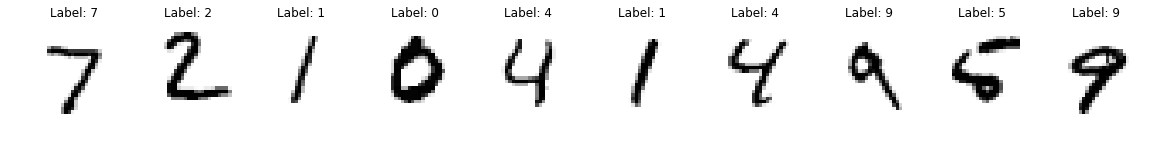

Decoder Output Images


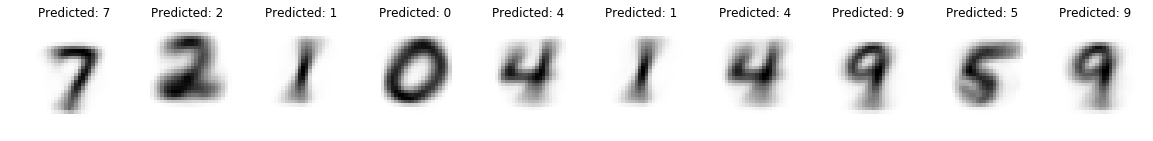

In [16]:
sample_images = sample_images.reshape([-1, 28, 28])
reconst_image = decoder_out_val.reshape([-1, 28,28])

print('Input Images')
plt.figure(figsize = (n_samples * 2, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    plt.imshow(sample_images[i], cmap='binary')
    plt.title('Label: ' + str(y_test[i]))
    plt.axis('off')
    
plt.show()

print('Decoder Output Images')
plt.figure(figsize = (n_samples * 2, 3))
for i in range(n_samples):
    plt.subplot(1, n_samples, i + 1)
    plt.title('Predicted: ' + str(np.argmax(y_pred_val[i])))
    plt.imshow(reconst_image[i], cmap='binary')
    plt.axis('off')

plt.show()

In [18]:
for i in range(len(y_pred_val)):
    print(np.max(y_pred_val[i]))
    print(np.argmax(y_pred_val[i]))


0.5704209
7
0.2480579
2
0.5752627
1
0.5237801
0
0.59852993
4
0.57525885
1
0.61095136
4
0.4069945
9
0.35965145
5
0.39792854
9


In [19]:
print(y_pred_val[1])

[0.00190251 0.0038042  0.2480579  0.05385483 0.0102572  0.16156174
 0.04285438 0.13219489 0.00058588 0.04295   ]
